In [2]:
#DATA AUGMENTATION

# Importing necessary functions
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os

def augment_images(image_path, filename):
		# Loading a sample image
		img = load_img(image_path)
		# Converting the input sample image to an array
		x = img_to_array(img)
		# Reshaping the input image
		x = x.reshape((1, ) + x.shape)

		# Generating and saving 5 augmented samples
		# using the above defined parameters.
		i = 0
		for batch in datagen.flow(x, batch_size = 16,
								save_to_dir ='C:/Users/Camille/Downloads/NEW PATH', #Camille
								# save_to_dir ='D:/Program Files/NEW CROPPED LABELED RESIZED PRES PICS', #Ash
								save_prefix =filename+'_'+str(i), save_format ='jpg'):
			i += 1
			if i > 5:
				break

# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
		rotation_range = 5,
		shear_range = 1,
		zoom_range = 0.2,
		rescale=1)

input_path = 'C:/Users/Camille/Downloads/CROPPED LABELED RESIZED PRES PICS' #Camille
# input_path = 'D:\Program Files\CROPPED LABELED RESIZED PRES PICS' #Ash
for filename in os.listdir(input_path):
	if filename.endswith(".jpg"):
		image_path = os.path.join(input_path, filename)
		augment_images(image_path, filename[:-4])

In [3]:
# # Creating Train / Val / Test folders (One time use)
import os
import numpy as np
import shutil
import random
root_dir = 'C:/Users/Camille/Downloads/splitted data/' #Camille
# root_dir = 'D:/Program Files/SPLIT NEW CROPPED LABELED RESIZED PRES PICS/' #Ash


val_ratio = 0
test_ratio = 0.3

os.makedirs(root_dir +'train/')
os.makedirs(root_dir +'test/')

# Creating partitions of the data after shuffeling
src = 'C:/Users/Camille/Downloads/NEW PATH' # Folder to copy images from --Camille
# src = 'D:/Program Files/NEW CROPPED LABELED RESIZED PRES PICS' #Ash


allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
#print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, root_dir +'train/' )

#for name in val_FileNames:
 #   shutil.copy(name, root_dir +'val/' + cls)

for name in test_FileNames:
    shutil.copy(name, root_dir +'test/' )

Total images:  72
Training:  50
Testing:  22


In [1]:
#BINARIZATION
import cv2
import numpy as np
from skimage.filters import threshold_otsu

def binary(image):
    (thresh, im_bw) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    thresh = 127
    im_bw = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]
    return im_bw

In [2]:
#NOISE REMOVAL
import bm3d
def noise(bw):
    # den = bm3d.bm3d(bw, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    den = cv2.fastNlMeansDenoising(bw, None, 10, 7, 15)
    return den

In [3]:
#CED
from scipy import signal

def ced(image):
    m1 = np.array([[5, 5, 5],[-3,0,-3],[-3,-3,-3]])
    m8 = np.array([[-3, 5,5],[-3,0,5],[-3,-3,-3]])
    m7 = np.array([[-3,-3,5],[-3,0,5],[-3,-3,5]])
    m6 = np.array([[-3,-3,-3],[-3,0,5],[-3,5,5]])
    m5 = np.array([[-3, -3, -3],[-3,0,-3],[5,5,5]])
    m4 = np.array([[-3, -3, -3],[5,0,-3],[5,5,-3]])
    m3 = np.array([[5, -3, -3],[5,0,-3],[5,-3,-3]])
    m2 = np.array([[5, 5, -3],[5,0,-3],[-3,-3,-3]])
    list_m = [m1,m2,m3,m4,m5,m6,m7,m8]

    list_e = []
    count = 1
    
    for m in list_m:
        imgk = signal.convolve2d(image, m,boundary='symm')
        list_e.append(np.abs(imgk))
        out = imgk.astype(np.uint8)
        count += 1
    #Seeking maximum
    count
    e = list_e[0]
    for i in range(len(list_e)):
        e = e*(e>=list_e[i]) + list_e[i]*(e<list_e[i])
        
    e[e>255] = 255
    e=e.astype(np.uint8)
    return e

In [4]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

def skeleton(image):
    return cv2.ximgproc.thinning(image)


In [6]:
#PREPROCESSING IMAGES
import time
import matplotlib.image as imgsave
# import pandas as pd
filename = 'C:/Users/Camille/Downloads/splitted data/train/'
filename2 = 'C:/Users/Camille/Downloads/splitted data/test/'
# filename = 'D:/Program Files/SPLIT NEW CROPPED LABELED RESIZED PRES PICS/train/' #Ash
# filename2 = 'D:/Program Files/SPLIT NEW CROPPED LABELED RESIZED PRES PICS/test/' #Ash

def preprocess(train_dir):
    start_time = time.time()
    list_images = []
    for filename in os.listdir(train_dir):
        image = cv2.imread(os.path.join(train_dir, filename),0)
        img2 = binary(image)
        img3 = noise(img2)
        imgg = cv2.blur(img3,(3,3))
        img4 = ced(imgg)
        img5 = skeleton(img4)
        list_images.append(img5)
    print("--- %s seconds --- skeleton image" % (time.time() - start_time))
    list_images = np.array(list_images, np.int64)
    return list_images

list_train_images = preprocess(filename)
list_test_images = preprocess(filename2)
print(list_train_images)
print(list_test_images)

# filepath='C:/Users/Camille/Downloads/pagod na ko/'

# image = cv2.imread('C:/Users/Camille/Downloads/splitted data/train/Hydroxyzine_0_8889.jpg',0)

# img = binary(image)
# img2 = noise(img)

# img3 = cv2.blur(img2, ksize=(3,3))

# img4 = ced(img3)
# img5 = skeleton(img4)

# cv2.imwrite(os.path.join(filepath,"1grey.jpg"), image)  
# cv2.imwrite(os.path.join(filepath,"2binary.jpg"), img)  
# cv2.imwrite(os.path.join(filepath,"3noise.jpg"), img2)  
# cv2.imwrite(os.path.join(filepath,"4blur.jpg"), img3)  
# cv2.imwrite(os.path.join(filepath,"5ced.jpg"), img4) 
# cv2.imwrite(os.path.join(filepath,"6skeleton.jpg"), img5) 


--- 365.970472574234 seconds --- skeleton image
--- 184.26021790504456 seconds --- skeleton image
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]



In [9]:
# import tensorflow as tf

# from tensorflow.keras import datasets, layers, models
# import matplotlib.pyplot as plt

# (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# # print(train_images)
# image = cv2.imread(os.path.join(filepath,"6skeleton.jpg"))
# image2 = cv2.imread(os.path.join(filepath,"6skeleton.jpg"))
# list1 = []
# list1.append(image)
# list1.append(image2)
# list2 = np.array(list1, np.int32)
# print(list2)


In [34]:
#CNN ASH
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby


In [19]:
image_paths = []
image_texts = []

# data_folder = "D:/Program Files/SPLIT NEW CROPPED LABELED RESIZED PRES PICS/train" #Ash
data_folder = 'C:/Users/Camille/Downloads/splitted data/train/'

for filename in os.listdir(data_folder):
    image_paths.append(data_folder + "/" + filename)
    # image_texts.append(filename.split("/")[0])
    if filename.find("Azathioprine") != -1:
        image_texts.append("Azathioprine: 3-5 mg/kg Per os OD")
    elif filename.find("Ceftriaxone") != -1:
        image_texts.append("Ceftriaxone: 2 g IV q24h")
    elif filename.find("Chlorpromazine") != -1:
        image_texts.append("Chlorpromazine: 10-25 mg Per os three times a day")
    elif filename.find("Dobutamine") != -1:
        image_texts.append("Dobutamine: 2.5-15 mcg/kg/min")
    elif filename.find("Hydroxyzine") != -1:
        image_texts.append("Hydroxyzine: 50-100 mg by IJ qds")
    elif filename.find("Lorazepam") != -1:
        image_texts.append("Lorazepam: 1 mg Per os 2 times a day")
    elif filename.find("Metronidazole") != -1:
        image_texts.append("Metronidazole: 7.5 mg/kg Per os q6hr")
    elif filename.find("Prednisolone") != -1:
        image_texts.append("Prednisolone: 5-60 mg per day qds")
    elif filename.find("Quinine") != -1:
        image_texts.append("Quinine: 648 mg Per os every 8 hours for 7 days")
    elif filename.find("Risperidone") != -1:
        image_texts.append("Risperidone: 2 mg orally i/d")
    elif filename.find("Rituximab") != -1:
        image_texts.append("Rituximab: 375 mg/m2 IV once weekly")
    else:
        image_texts.append("Tramadol: 50-100 mg as needed every 4 to 6 hours")

In [20]:
image_paths[:10], image_texts[:10]

(['C:/Users/Camille/Downloads/splitted data/train//DeLosSantos_Azathioprine_1_0_0_5566.jpg',
  'C:/Users/Camille/Downloads/splitted data/train//DeLosSantos_Azathioprine_1_0_0_8292.jpg',
  'C:/Users/Camille/Downloads/splitted data/train//DeLosSantos_Azathioprine_1_0_0_8445.jpg',
  'C:/Users/Camille/Downloads/splitted data/train//DeLosSantos_Azathioprine_1_0_0_8777.jpg',
  'C:/Users/Camille/Downloads/splitted data/train//DeLosSantos_Ceftriaxone_1_0_0_5665.jpg',
  'C:/Users/Camille/Downloads/splitted data/train//DeLosSantos_Ceftriaxone_1_0_0_8161.jpg',
  'C:/Users/Camille/Downloads/splitted data/train//DeLosSantos_Chlorpromazine_1_0_0_6602.jpg',
  'C:/Users/Camille/Downloads/splitted data/train//DeLosSantos_Chlorpromazine_1_0_0_6880.jpg',
  'C:/Users/Camille/Downloads/splitted data/train//DeLosSantos_Chlorpromazine_1_0_0_711.jpg',
  'C:/Users/Camille/Downloads/splitted data/train//DeLosSantos_Chlorpromazine_1_0_0_9229.jpg'],
 ['Azathioprine: 3-5 mg/kg Per os OD',
  'Azathioprine: 3-5 mg/k

In [21]:
vocab = set(['-', '.', '/','0','1','2','3','4','5','6','7','8',':','A','C','D','H','I','J','L','M','O','P','Q','R','T','V','a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' '])
print(sorted(vocab))

[' ', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', ':', 'A', 'C', 'D', 'H', 'I', 'J', 'L', 'M', 'O', 'P', 'Q', 'R', 'T', 'V', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [22]:
max_label_len = 49
max_label_len

49

In [23]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
    
    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]

In [24]:
padded_image_texts = list(map(encode_to_labels, image_texts))

padded_image_texts[0]

array([14, 52, 28, 46, 35, 36, 41, 42, 44, 36, 40, 32, 13,  0,  7,  1,  9,
        0, 39, 34,  3, 37, 34,  0, 23, 32, 44,  0, 41, 45,  0, 22, 16, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53])

In [25]:
train_image_paths = image_paths[ : int(len(image_paths) * 0.90)]
train_image_texts = padded_image_texts[ : int(len(image_texts) * 0.90)]

val_image_paths = image_paths[int(len(image_paths) * 0.90) : ]
val_image_texts = padded_image_texts[int(len(image_texts) * 0.90) : ]

In [26]:
def process_single_sample(img_path, label):

    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [32, 128])

    return {"image": img, "label": label}

In [20]:
process_single_sample('D:/Program Files/SPLIT NEW CROPPED LABELED RESIZED PRES PICS/train/Azathioprine_0_2250.jpg', [1,2,3,4])


{'image': <tf.Tensor: shape=(32, 128, 1), dtype=float32, numpy=
 array([[[0.97647065],
         [0.97647065],
         [0.97647065],
         ...,
         [0.98823535],
         [0.9843138 ],
         [0.9843138 ]],
 
        [[0.97647065],
         [0.97647065],
         [0.97647065],
         ...,
         [0.9822304 ],
         [0.97830886],
         [0.9843138 ]],
 
        [[0.97647065],
         [0.97647065],
         [0.97647065],
         ...,
         [0.98823535],
         [0.98823535],
         [0.98823535]],
 
        ...,
 
        [[0.98125005],
         [0.9843138 ],
         [0.9803922 ],
         ...,
         [0.9921569 ],
         [0.9921569 ],
         [0.9921569 ]],
 
        [[0.986152  ],
         [0.9843138 ],
         [0.986152  ],
         ...,
         [0.9921569 ],
         [0.9921569 ],
         [0.9921569 ]],
 
        [[0.98370105],
         [0.98370105],
         [0.9797795 ],
         ...,
         [0.9921569 ],
         [0.9921569 ],
         [0.99215

In [27]:
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_texts))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_texts))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

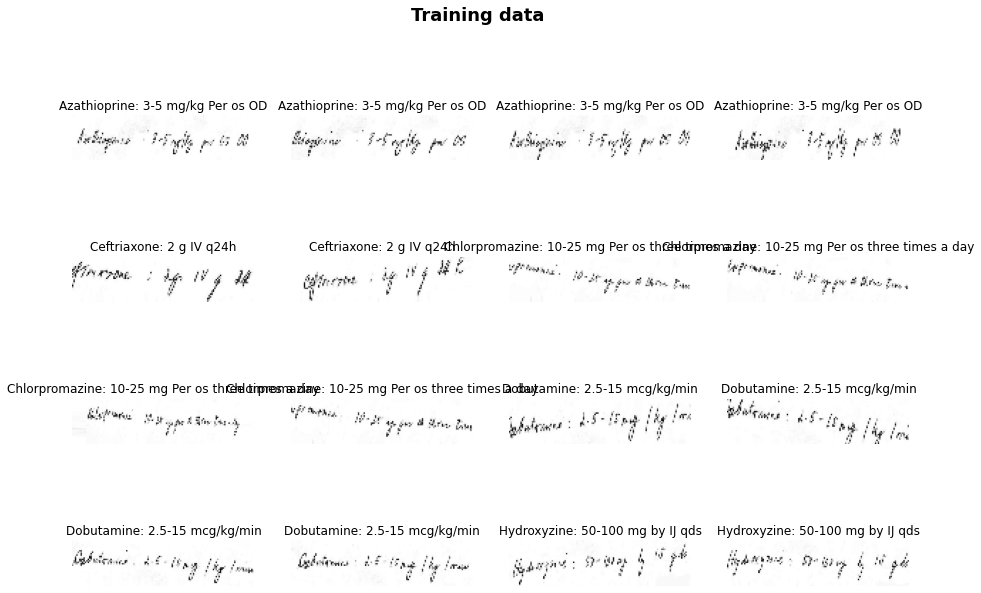

In [28]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_list, num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

train_data_fig, ax = plt.subplots(4, 4, figsize=(15, 10))
train_data_fig.suptitle('Training data', weight='bold', size=18)


for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")

        label = label.replace('[UNK]', '')
        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
    
plt.show()

In [73]:
class CTCLayer(layers.Layer):

    def __init__(self, name=None):
        
        super().__init__(name=name)        
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [74]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]
        
        text_list.append(ans)
        
    return text_list


In [75]:
figures_list = []

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, frequency=1):
        self.frequency = frequency
        super(PlotPredictions, self).__init__()

        batch = validation_dataset.take(1)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = prediction_model.predict(self.batch_images)
        pred_texts = ctc_decoder(preds)

        orig_texts = []

        for label in self.batch_labels:
            orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

        fig , ax = plt.subplots(4, 4, figsize=(15, 5))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(16):

            img = (self.batch_images[i, :, :, 0] * 255).astype(np.uint8)
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        
        plt.show()
        #plt.savefig("predictions_epoch_"+ str(epoch)+'.png', bbox_inches = 'tight', pad_inches = 0)
        
        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch) 
            figures_list = []

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, frequency=1):
        self.frequency = frequency
        super(PlotPredictions, self).__init__()

        batch = validation_dataset.take(1)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = prediction_model.predict(self.batch_images)
        pred_texts = ctc_decoder(preds)

        orig_texts = []

        for label in self.batch_labels:
            orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

        fig , ax = plt.subplots(4, 4, figsize=(15, 5))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(16):

            img = (self.batch_images[i, :, :, 0] * 255).astype(np.uint8)
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        
        plt.show()
        #plt.savefig("predictions_epoch_"+ str(epoch)+'.png', bbox_inches = 'tight', pad_inches = 0)
        
        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch)

In [76]:
def train(epochs):
    
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32, 128, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)


    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    #model to be used at training time
    model = Model(inputs=[inputs, labels], outputs=output)
    model.compile(optimizer = optimizer)

    print(model.summary())
    file_path = "C_LSTM_best.hdf5"
    
    checkpoint = ModelCheckpoint(filepath=file_path, 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='min')

    callbacks_list = [checkpoint, 
                      PlotPredictions(frequency=1),
                      EarlyStopping(patience=3, verbose=1)]

    history = model.fit(train_dataset, 
                        epochs = epochs,
                        validation_data=validation_dataset,
                        verbose = 1,
                        callbacks = callbacks_list,
                        shuffle=True)
    
    return model

In [77]:
model = train(epochs=30)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 32, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 32, 128, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 16, 64, 32)   0           conv2d_63[0][0]                  
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 16, 64, 64)   18496       max_pooling2d_36[0][0]           
____________________________________________________________________________________________

InvalidArgumentError:  Not enough time for target transition sequence (required: 49, available: 31)0You can turn this error into a warning by using the flag ignore_longer_outputs_than_inputs
	 [[node model_7/ctc_loss/CTCLoss (defined at \AppData\Local\Temp/ipykernel_21420/4034368426.py:18) ]] [Op:__inference_train_function_102450]

Function call stack:
train_function


In [ ]:
#CNN CAM

In [ ]:
#CNN TRIX

In [ ]:
#CNN CARL